In [92]:
#dataset: https://www.kaggle.com/thedagger/pokemon-generation-one
import tensorflow as tf
import numpy as np
import PIL
import os
import random
from PIL import Image
import tensorflow_datasets as tfds
from google.colab import drive
import pathlib
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [93]:
# mounts to google drive. Upload training dataset titled "dataset", and testing dataset titled
# "testet" to your google drive. Datasets can then be found at /content/drive/MyDrive/xxxx
drive.mount('/content/drive')

datasetFilePath = '/content/drive/MyDrive/dataset/'
dataDirectory = pathlib.Path(datasetFilePath)

testsetFilePath = '/content/drive/MyDrive/testset/'
testDirectory = pathlib.Path(testsetFilePath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
# This function converts all images from google drive dataset folder to the same
# format. Converts all .png -> .rgb
print("There are " + str(len(list(dataDirectory.glob('*/*.jpg')))) + " .jpg images") #1024 (were 913 before conversion) jpg files
print("There are " + str(len(list(dataDirectory.glob('*/*.png')))) + " .png images") #0 (were 173 before conversion) png files
pngImages = list(dataDirectory.glob('*/*.png'))
for i in range(0, len(pngImages)):
  # convert .png images to .rgb and save them
  oldImagePath = str(pngImages[i])
  image = Image.open(oldImagePath)
  image = image.convert('RGB')
  newImagePath = oldImagePath.split(".png")[0] + ".jpg"
  image.save(newImagePath)

  #remove old .png file
  os.remove(oldImagePath)
print("All images converted to .jpg format")

There are 948 .jpg images
There are 0 .png images
All images converted to .jpg format


In [95]:
# Resizes images to the same scale. Scale is set to be the average size of all 
# photos in the set
images = list(dataDirectory.glob('*/*.jpg'))

sumImageWidth = 0
sumImageHeight = 0

# find avg height and width of images in dataset. Also removes images that are
# exceptionally large
for i in range(0, len(images)):
  try:
    image = Image.open(str(images[i]))
    currentWidth, currentHeight = image.size
    # remove images that had outlier size
    if (currentWidth > 2000):
      print("Removing image that is too large at ... " + str(images[i]))
      os.remove(str(images[i]))
    else:
      sumImageWidth += currentWidth
      sumImageHeight += currentHeight
  except:
    print("Removing image due to opening error at ... " + str(images[i]))
    os.remove(str(images[i]))

#avgImageWidth = int(sumImageWidth / len(images)) # = 784
#avgImageHeight = int(sumImageHeight / len(images)) # = 704
avgImageWidth = 784
avgImageHeight = 704

print("(average width, average height) => " + str(avgImageWidth) + ", " + str(avgImageHeight))

# now go through and resize all of the images in the dataset to be the avg size 
# all the images in the dataset
images = list(dataDirectory.glob('*/*.jpg'))
for i in range(0, len(images)):
  try:
    image = Image.open(str(images[i]))
    currentWidth, currentHeight = image.size
    if (currentWidth != avgImageWidth or currentHeight != avgImageHeight):
      image = image.resize((avgImageWidth, avgImageHeight))
      os.remove(str(images[i]))
      image.save(str(images[i]))
  except:
    print("Error re-sizing image, removing at ..." + str(images[i]))
    try: os.remove(str(images[i]))
    except FileNotFoundError: print("File Not Found Error at file ..." + str(images[i]))

print("All images resized to their summed average size, (width, height) => (" + str(avgImageWidth) + ", " + str(avgImageHeight) + ")")

(average width, average height) => 784, 704
All images resized to their summed average size, (width, height) => (784, 704)


In [96]:
# Split data into training, validation, and testing

batchSize = 32
imageHeight = avgImageHeight
imageWidth = avgImageWidth
print("Splitting data into training and testing sets...")

# use 80% of images from taining set for training
trainingDataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataDirectory,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 321,
    image_size = (imageHeight, imageWidth),
    batch_size = batchSize)

# use remaining 20% of images from training set for validation
validationDataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataDirectory,
    validation_split = 0.2,
    subset = "validation",
    seed = 321,
    image_size = (imageHeight, imageWidth),
    batch_size = batchSize)

# Use separate dataset for testing
testDataset = tf.keras.preprocessing.image_dataset_from_directory(
    testDirectory,
    validation_split = 0.1,
    subset = "training",
    shuffle = False,
    image_size = (avgImageHeight, avgImageWidth),
    batch_size = 1)



Splitting data into training and testing sets...
Found 951 files belonging to 15 classes.
Using 761 files for training.
Found 951 files belonging to 15 classes.
Using 190 files for validation.
Found 1303 files belonging to 15 classes.
Using 1173 files for training.


In [6]:
# Build and train convolutional neural network on training data

classNames = trainingDataset.class_names
batchSize = 32

# Early stopping to prevent overfitting:
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0,
    patience = 4,
    restore_best_weights= True,
)

cnnModel = tf.keras.Sequential([
                                # Standardize RGB image values to be in the [0, 1] range
                                layers.experimental.preprocessing.Rescaling(1./255),

                                tf.keras.layers.Conv2D(filters = 32, kernel_size = (2, 2), activation = tf.nn.relu),
                                tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
                                tf.keras.layers.Conv2D(filters = 32, kernel_size = (2, 2), activation = tf.nn.relu),
                                tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
                                tf.keras.layers.Conv2D(filters = 32, kernel_size= (2, 2), activation=tf.nn.relu),
                                tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

                                layers.Flatten(),
                                
                                # Now build the network
                                tf.keras.layers.Dense(500, activation = tf.nn.relu),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Dense(120, activation = tf.nn.relu),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Dense(84, activation = tf.nn.relu),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Dense(len(classNames))
])

cnnModel.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

modelHistory = cnnModel.fit(
    trainingDataset,
    validation_data = validationDataset,
    callbacks=[earlyStop],
    epochs = 17)

print("Number of epochs ran before overfitting: " + str(len(modelHistory.history['loss'])))

Epoch 1/17
24/24 [==============================] - 432s 18s/step - loss: 7.1775 - accuracy: 0.1340 - val_loss: 2.4001 - val_accuracy: 0.3526
Epoch 2/17
24/24 [==============================] - 433s 18s/step - loss: 2.2758 - accuracy: 0.3108 - val_loss: 2.1193 - val_accuracy: 0.3632
Epoch 3/17
24/24 [==============================] - 439s 18s/step - loss: 1.8763 - accuracy: 0.4227 - val_loss: 1.9201 - val_accuracy: 0.4053
Epoch 4/17
24/24 [==============================] - 446s 19s/step - loss: 1.6957 - accuracy: 0.4671 - val_loss: 1.8490 - val_accuracy: 0.4158
Epoch 5/17
24/24 [==============================] - 452s 19s/step - loss: 1.5701 - accuracy: 0.4884 - val_loss: 1.8933 - val_accuracy: 0.4263
Epoch 6/17
24/24 [==============================] - 454s 19s/step - loss: 1.4793 - accuracy: 0.5475 - val_loss: 1.7780 - val_accuracy: 0.4474
Epoch 7/17
24/24 [==============================] - 455s 19s/step - loss: 1.3528 - accuracy: 0.5677 - val_loss: 1.6650 - val_accuracy: 0.5000
Epoch 

In [87]:
# Evaluate cnn on testing data
cnnModel.evaluate(testDataset)

1173/1173 [==============================] - 303s 258ms/step - loss: 0.9965 - accuracy: 0.7621


[0.9965484142303467, 0.7621483206748962]

In [97]:
# Below two cells are used to give the live demo (1 of 2)

classLabels = {
    0 : "Abra",
    1 : "Aerodactyl",
    2 : "Alakazam",
    3 : "Arbok",
    4 : "Arcanine",
    5 : "Articuno",
    6 : "Beedrill",
    7 : "Bellsprout",
    8 : "Blastoise",
    9 : "Bulbasaur",
    10 : "Butterfree",
    11 : "Caterpie",
    12 : "Chansey",
    13 : "Charizard",
    14 : "Charmander",
}

fileNames = testDataset.file_paths
predictions = cnnModel.predict_classes(testDataset)

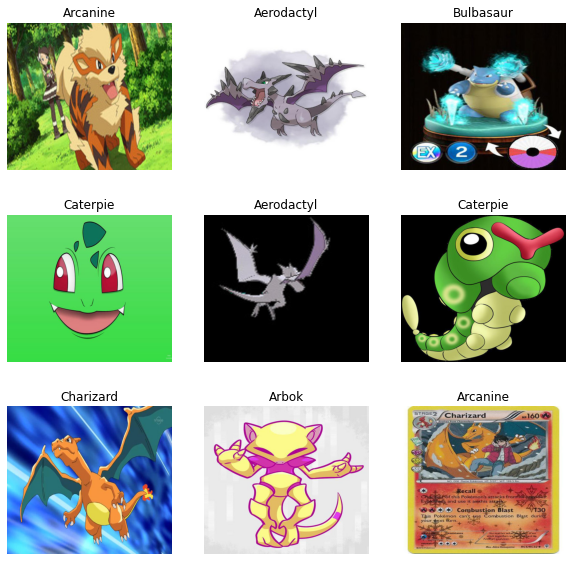

In [98]:
# Used to give the live demo (2 of 2)

plt.figure(figsize=(10, 10))
for i in range(9):
  j = random.randrange(0, len(predictions) - 1)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(Image.open(str(fileNames[j])))
  plt.title(classLabels[predictions[j]])
  plt.axis("off")